In [1]:
import torch, torchaudio, torchvision.transforms as transforms, matplotlib.pyplot as plt, torch.nn as nn, torch.optim as optim, numpy as np
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import  StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, auc, classification_report, roc_auc_score
from torch.autograd import grad

print(torch.cuda.device_count())
cuda0 = torch.device("cuda:0")
cuda1 = torch.device("cuda:1")
device = cuda1
print(torch.cuda.get_device_name(device) if torch.cuda.is_available() else "No GPU available")
data = np.load("../../hvcm/RFQ.npy", allow_pickle=True)
label = np.load("../../hvcm/RFQ_labels.npy", allow_pickle=True)
label = label[:, 1]  # Assuming the second column is the label
label = (label == "Fault").astype(int)  # Convert to binary labels
print(data.shape, label.shape)

normal_data = data[label == 0]
faulty_data = data[label == 1]

normal_label = label[label == 0]
faulty_label = label[label == 1]


2
NVIDIA A30
(872, 4500, 14) (872,)


# Conditional GAN

In [2]:
# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim=100, num_classes=2):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.init_size = (14, 2, 2, 2)
        input_dim = latent_dim + num_classes
        self.l1 = nn.Sequential(nn.Linear(input_dim, int(torch.prod(torch.tensor(self.init_size)))))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm3d(14),
            nn.Upsample(scale_factor=2),
            nn.Conv3d(14, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(512, 0.8),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2),
            nn.Conv3d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(256, 0.8),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=(2, 2, 2)),
            nn.Conv3d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(128, 0.8),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=(2, 2, 2)),
            nn.Conv3d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64, 0.8),
            nn.ReLU(inplace=True),

            nn.Conv3d(64, 14, kernel_size=3, stride=1, padding=1),
            nn.Upsample(size=(10, 15, 30)),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_input = self.label_emb(labels)
        gen_input = torch.cat((z, label_input), dim=1)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], *self.init_size)
        return self.conv_blocks(out)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, num_classes=2):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, 10)
        self.label_proj = nn.Linear(10, 10 * 15 * 30)  # Match spatial dimensions

        self.conv = nn.Sequential(
            nn.Conv3d(14 + 1, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv3d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm3d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv3d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm3d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.AdaptiveAvgPool3d((1, 1, 1))
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 1)
        )

    def forward(self, x, labels):
        label_input = self.label_emb(labels)
        label_map = self.label_proj(label_input).view(x.size(0), 1, 10, 15, 30)
        x = torch.cat((x, label_map), dim=1)
        x = self.conv(x)
        return self.fc(x)



# Conditional GAN Training

In [3]:
# Training parameters
n_epochs = 50
n_classes = 2  # Assuming binary classification
batch_size = 128
lambda_gp = 20
n_critic = 3

best_g_loss = float('inf')
epochs_no_improve = 0
patience = 5  # You can adjust this

# Initialize models
latent_dim = 100
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
adversarial_loss = nn.BCEWithLogitsLoss().to(device)
optimizer_G = optim.Adam(generator.parameters(), lr=0.009)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.00005)




# Training loop
# Training loop
for epoch in range(n_epochs):
    for i in range(0, len(normal_data), batch_size):
        # Prepare real samples and labels
        real_samples = torch.tensor(normal_data[i:i + batch_size], dtype=torch.float32).to(device)
        real_labels_np = normal_label[i:i + batch_size]
        # Ensure all labels are in [0, 1]
        assert np.all((real_labels_np >= 0) & (real_labels_np < n_classes)), f"Label out of range: {real_labels_np}"
        real_labels = torch.tensor(real_labels_np, dtype=torch.long).to(device)
        # Remove print for performance, but keep assertion

        current_batch_size = real_samples.shape[0]

        # Reshape to [B, 14, 10, 15, 30]
        real_samples_reshaped = real_samples.permute(0, 2, 1).reshape(-1, 14, 10, 15, 30)

        # Adversarial ground truths
        valid = torch.ones(current_batch_size, 1).to(device)
        fake = torch.zeros(current_batch_size, 1).to(device)

        # ---------------------
        #  Train Generator
        # ---------------------
        optimizer_G.zero_grad()

        z = torch.randn(current_batch_size, latent_dim).to(device)
        gen_labels = torch.randint(0, n_classes, (current_batch_size,)).to(device)

        gen_samples = generator(z, gen_labels)
        g_loss = adversarial_loss(discriminator(gen_samples, gen_labels), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        real_loss = adversarial_loss(discriminator(real_samples_reshaped, real_labels), valid)
        fake_loss = adversarial_loss(discriminator(gen_samples.detach(), gen_labels), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        if i % 100 == 0:
            print(f"[Epoch {epoch + 1}/{n_epochs}] [Batch {i}/{len(normal_data)}] "
                  f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")
    # # Early stopping check
    # if g_loss.item() < best_g_loss:
    #     best_g_loss = g_loss.item()
    #     epochs_no_improve = 0
    # else:
    #     epochs_no_improve += 1

    # if epochs_no_improve >= patience:
    #     print(f"Early stopping triggered at epoch {epoch}")
    #     break





[Epoch 1/50] [Batch 0/690] [D loss: 0.7066] [G loss: 0.7830]
[Epoch 2/50] [Batch 0/690] [D loss: 0.6810] [G loss: 0.7660]
[Epoch 3/50] [Batch 0/690] [D loss: 0.6788] [G loss: 0.7519]
[Epoch 4/50] [Batch 0/690] [D loss: 0.6747] [G loss: 0.7386]
[Epoch 5/50] [Batch 0/690] [D loss: 0.6578] [G loss: 0.7341]
[Epoch 6/50] [Batch 0/690] [D loss: 0.6435] [G loss: 0.7411]
[Epoch 7/50] [Batch 0/690] [D loss: 0.6334] [G loss: 0.7503]
[Epoch 8/50] [Batch 0/690] [D loss: 0.6225] [G loss: 0.7505]
[Epoch 9/50] [Batch 0/690] [D loss: 0.6115] [G loss: 0.7521]
[Epoch 10/50] [Batch 0/690] [D loss: 0.6034] [G loss: 0.7560]
[Epoch 11/50] [Batch 0/690] [D loss: 0.5943] [G loss: 0.7664]
[Epoch 12/50] [Batch 0/690] [D loss: 0.5830] [G loss: 0.7821]
[Epoch 13/50] [Batch 0/690] [D loss: 0.5751] [G loss: 0.7961]
[Epoch 14/50] [Batch 0/690] [D loss: 0.5689] [G loss: 0.8040]
[Epoch 15/50] [Batch 0/690] [D loss: 0.5617] [G loss: 0.8101]
[Epoch 16/50] [Batch 0/690] [D loss: 0.5541] [G loss: 0.8222]
[Epoch 17/50] [Ba

# Generate and Combine

In [4]:
generator = Generator(latent_dim, num_classes=2).to(device)
generator.eval()

num_samples = len(data[label == 0])  # Number of synthetic samples to generate
batch_size = 64

generated_list = []
for i in range(0, num_samples, batch_size):
    current_batch = min(batch_size, num_samples - i)
    z = torch.randn(current_batch, latent_dim).to(device)

    # Set desired label for generation (e.g., class 0)
    gen_labels = torch.zeros(current_batch, dtype=torch.long).to(device)  # or torch.ones(...) for class 1

    with torch.no_grad():
        batch_samples = generator(z, gen_labels).cpu().numpy()

    # Reshape to match your previous format
    batch_samples = batch_samples.reshape(current_batch, 14, -1).transpose(0, 2, 1)  # (current_batch, 4500, 14)
    generated_list.append(batch_samples)

generated_samples = np.concatenate(generated_list, axis=0)  # (num_samples, 4500, 14)

# Combine with real data
combine_data_normal = np.concatenate((generated_samples, normal_data), axis=0)
combine_labels_normal = np.concatenate((np.zeros(num_samples), normal_label), axis=0)


# Processing: Mel Spec > Resizing > Feature Extraction

In [5]:
# Resize and convert to 3-channel image
def resize_spectrogram(spectrogram):
    spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min() + 1e-6)
    spectrogram = np.uint8(spectrogram.cpu().numpy() * 255)
    spectrogram = np.stack([spectrogram] * 3, axis=-1)
    image = Image.fromarray(spectrogram)
    image = transforms.Resize((224, 224))(image)
    return transforms.ToTensor()(image)

# Process dataset
def process_dataset(data):
    num_samples, _, num_channels = data.shape
    features = np.zeros((num_samples, num_channels, 4096))
    mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=2500000, n_mels=128).to(device)
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1).to(device)
    model.classifier = model.classifier[:-3]
    model.eval()

    for i in range(num_samples):
        for j in range(num_channels):
            ts = torch.tensor(data[i, :, j], dtype=torch.float32).to(device)
            mel = mel_transform(ts)
            img = resize_spectrogram(mel)
            with torch.no_grad():
                feat = model(img.unsqueeze(0).to(device))
            features[i, j, :] = feat.squeeze().cpu().numpy()
    return features

# AE Class

In [6]:
# Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size=4096):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64), 
            nn.ReLU(),
            nn.Linear(64, 32), 
            nn.ReLU(),
            nn.Linear(32, 16), 
            nn.ReLU(),
            nn.Linear(16, 8), 
            nn.ReLU(),
            nn.Linear(8, 4), 
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 16), 
            nn.ReLU(),
            nn.Linear(16, 32), 
            nn.ReLU(),
            nn.Linear(32, 64), 
            nn.ReLU(),
            nn.Linear(64, input_size), 
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))


# Train autoencoder
def train_autoencoder(features, epochs=20, batch_size=128):
    x = torch.tensor(features.reshape(-1, 4096), dtype=torch.float32).to(device)
    loader = DataLoader(TensorDataset(x), batch_size=batch_size, shuffle=True)
    model = Autoencoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss()

    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            inputs = batch[0]
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(loader):.6f}")
    return model

# Compute reconstruction errors
def compute_reconstruction_loss(model, data):
    model.eval()
    x = torch.tensor(data.reshape(-1, 4096), dtype=torch.float32).to(next(model.parameters()).device)
    loader = DataLoader(TensorDataset(x), batch_size=64)
    loss = []
    criterion = torch.nn.MSELoss(reduction='none')
    with torch.no_grad():
        for batch in loader:
            inputs = batch[0]
            outputs = model(inputs)
            batch_errors = criterion(outputs, inputs).mean(dim=1)
            loss.extend(batch_errors.cpu().numpy())
    return np.array(loss)

# 2. Find best threshold based on F1 score
def find_best_threshold(errors, labels):
    best_f1 = 0
    best_threshold = 0
    for threshold in np.linspace(min(errors), max(errors), 100):
        preds = (errors > threshold).astype(int)
        f1 = f1_score(labels, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold, best_f1

def evaluate_on_test_with_threshold_search(model, X_test, y_test):
    # Step 1: Flatten the test data
    n_samples, n_segments, n_features = X_test.shape
    X_test_flat = X_test.reshape(-1, n_features)

    # Step 2: Compute reconstruction errors per segment
    segment_errors = compute_reconstruction_loss(model, X_test_flat)

    # Step 3: Aggregate errors per sample (mean over segments)
    sample_errors = segment_errors.reshape(n_samples, n_segments).mean(axis=1)

    # Step 4: Find best threshold based on F1 score
    best_threshold = 0
    best_f1 = 0
    for threshold in np.linspace(sample_errors.min(), sample_errors.max(), 100):
        preds = (sample_errors > threshold).astype(int)
        f1 = f1_score(y_test, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    # Step 5: Predict using best threshold
    test_preds = (sample_errors > best_threshold).astype(int)

    # Step 6: Evaluate
    print(f"Best Threshold = {best_threshold:.6f}, Best F1 Score = {best_f1:.4f}")
    print("Evaluation on Test Set:")
    print("Accuracy =", accuracy_score(y_test, test_preds))
    print("Precision =", precision_score(y_test, test_preds))
    print("Recall =", recall_score(y_test, test_preds))
    print("F1 Score =", f1_score(y_test, test_preds))
    print("Confusion Matrix:\n", confusion_matrix(y_test, test_preds))



# Preprocessing

In [7]:
combine_data = np.concatenate((combine_data_normal, data[label == 1]), axis=0)  # Combine real and generated data
combine_label = np.concatenate((np.zeros(len(combine_labels_normal)), label[label == 1]), axis=0)  # Labels: 0 for real, 0 for generated

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scaled_data = StandardScaler().fit_transform(combine_data.reshape(-1, combine_data.shape[-1])).reshape(combine_data.shape)
features = process_dataset(scaled_data)
print("Features shape:", features.shape)

/home/chris/GANs/.venv/lib/python3.8/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Features shape: (1562, 14, 4096)


# Cross Validation with StandardScaler

Fold 1
Epoch 1/15, Loss: 0.666067
Epoch 2/15, Loss: 0.619197
Epoch 3/15, Loss: 0.615751
Epoch 4/15, Loss: 0.613264
Epoch 5/15, Loss: 0.611487
Epoch 6/15, Loss: 0.610936
Epoch 7/15, Loss: 0.610645
Epoch 8/15, Loss: 0.610315
Epoch 9/15, Loss: 0.610074
Epoch 10/15, Loss: 0.609963
Epoch 11/15, Loss: 0.609797
Epoch 12/15, Loss: 0.609722
Epoch 13/15, Loss: 0.609592
Epoch 14/15, Loss: 0.609514
Epoch 15/15, Loss: 0.609347
Best threshold: 0.5986145012306444, Best F1 Score: 0.18877551020408165


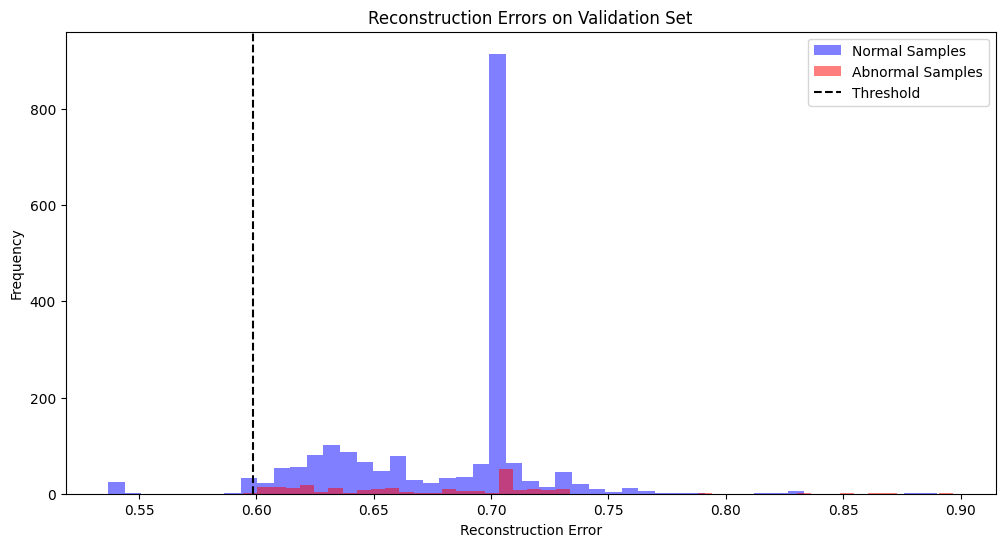

Best Threshold = 0.712384, Best F1 Score = 0.4138
Evaluation on Test Set:
Accuracy = 0.89171974522293
Precision = 0.75
Recall = 0.2857142857142857
F1 Score = 0.4137931034482759
Confusion Matrix:
 [[134   2]
 [ 15   6]]
Fold 2
Epoch 1/15, Loss: 0.673707
Epoch 2/15, Loss: 0.627013
Epoch 3/15, Loss: 0.618941
Epoch 4/15, Loss: 0.618037
Epoch 5/15, Loss: 0.616787
Epoch 6/15, Loss: 0.614604
Epoch 7/15, Loss: 0.613749
Epoch 8/15, Loss: 0.612519
Epoch 9/15, Loss: 0.611299
Epoch 10/15, Loss: 0.610726
Epoch 11/15, Loss: 0.610318
Epoch 12/15, Loss: 0.609995
Epoch 13/15, Loss: 0.609660
Epoch 14/15, Loss: 0.609285
Epoch 15/15, Loss: 0.608901
Best threshold: 0.7083370071468931, Best F1 Score: 0.27539503386004516


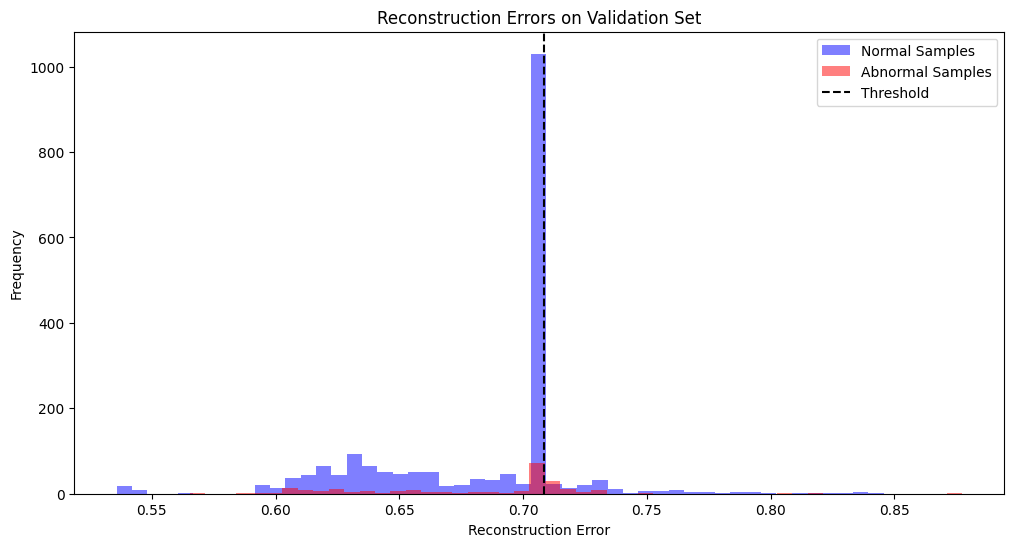

Best Threshold = 0.628411, Best F1 Score = 0.2260
Evaluation on Test Set:
Accuracy = 0.12738853503184713
Precision = 0.1282051282051282
Recall = 0.9523809523809523
F1 Score = 0.22598870056497172
Confusion Matrix:
 [[  0 136]
 [  1  20]]
Fold 3
Epoch 1/15, Loss: 0.665084
Epoch 2/15, Loss: 0.619315
Epoch 3/15, Loss: 0.615028
Epoch 4/15, Loss: 0.614089
Epoch 5/15, Loss: 0.613158
Epoch 6/15, Loss: 0.612454
Epoch 7/15, Loss: 0.611783
Epoch 8/15, Loss: 0.611155
Epoch 9/15, Loss: 0.610566
Epoch 10/15, Loss: 0.609999
Epoch 11/15, Loss: 0.609557
Epoch 12/15, Loss: 0.609077
Epoch 13/15, Loss: 0.608767
Epoch 14/15, Loss: 0.608514
Epoch 15/15, Loss: 0.608282
Best threshold: 0.7064573475808809, Best F1 Score: 0.25


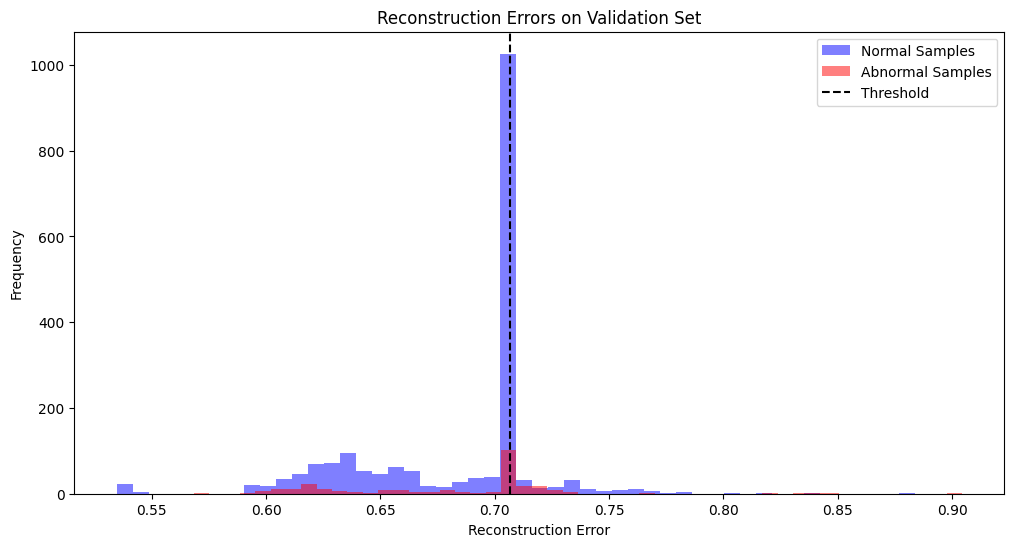

Best Threshold = 0.712781, Best F1 Score = 0.3333
Evaluation on Test Set:
Accuracy = 0.8974358974358975
Precision = 0.5
Recall = 0.25
F1 Score = 0.3333333333333333
Confusion Matrix:
 [[136   4]
 [ 12   4]]
Fold 4
Epoch 1/15, Loss: 0.682063
Epoch 2/15, Loss: 0.629854
Epoch 3/15, Loss: 0.629790
Epoch 4/15, Loss: 0.629801
Epoch 5/15, Loss: 0.629789
Epoch 6/15, Loss: 0.629761
Epoch 7/15, Loss: 0.629758
Epoch 8/15, Loss: 0.629740
Epoch 9/15, Loss: 0.629748
Epoch 10/15, Loss: 0.629759
Epoch 11/15, Loss: 0.629742
Epoch 12/15, Loss: 0.629736
Epoch 13/15, Loss: 0.629734
Epoch 14/15, Loss: 0.629737
Epoch 15/15, Loss: 0.629725
Best threshold: 0.5682556388354061, Best F1 Score: 0.2296964725184577


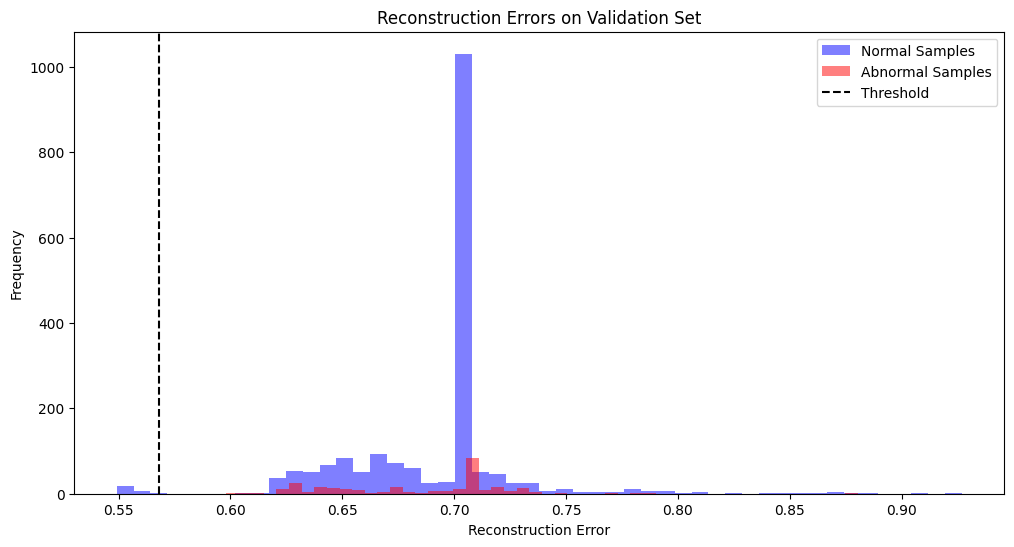

Best Threshold = 0.713437, Best F1 Score = 0.3200
Evaluation on Test Set:
Accuracy = 0.8910256410256411
Precision = 0.4444444444444444
Recall = 0.25
F1 Score = 0.32
Confusion Matrix:
 [[135   5]
 [ 12   4]]
Fold 5
Epoch 1/15, Loss: 0.657989
Epoch 2/15, Loss: 0.623779
Epoch 3/15, Loss: 0.615504
Epoch 4/15, Loss: 0.614506
Epoch 5/15, Loss: 0.613767
Epoch 6/15, Loss: 0.612245
Epoch 7/15, Loss: 0.610988
Epoch 8/15, Loss: 0.610486
Epoch 9/15, Loss: 0.610190
Epoch 10/15, Loss: 0.610000
Epoch 11/15, Loss: 0.609791
Epoch 12/15, Loss: 0.609496
Epoch 13/15, Loss: 0.609157
Epoch 14/15, Loss: 0.608791
Epoch 15/15, Loss: 0.608470
Best threshold: 0.5995850647338713, Best F1 Score: 0.23099293726630657


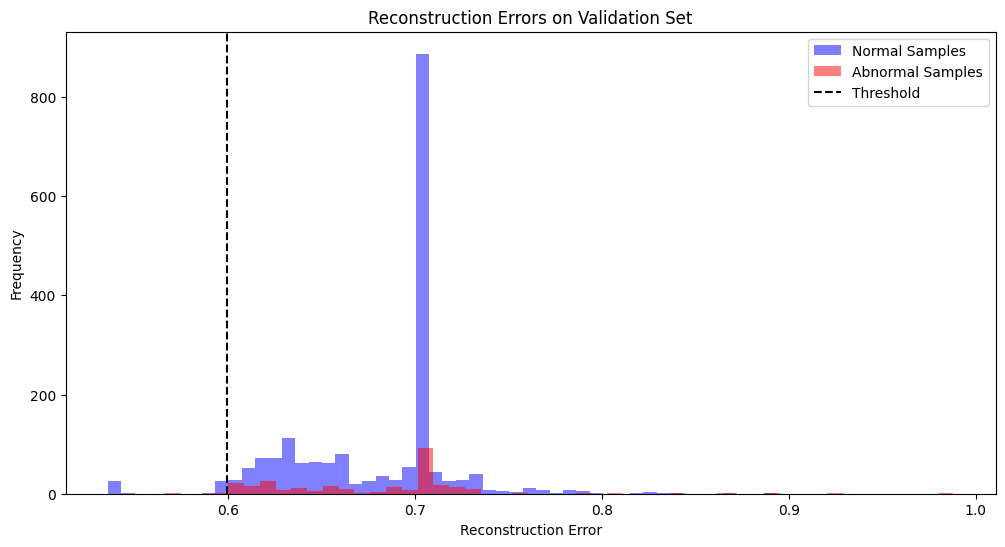

Best Threshold = 0.711439, Best F1 Score = 0.3000
Evaluation on Test Set:
Accuracy = 0.9102564102564102
Precision = 0.75
Recall = 0.1875
F1 Score = 0.3
Confusion Matrix:
 [[139   1]
 [ 13   3]]


In [8]:

for fold, (train_idx, val_idx) in enumerate(skf.split(features, combine_label)):
    
    print(f"Fold {fold + 1}")
    
    # Get full fold data
    fold_data, fold_labels = features[train_idx], combine_label[train_idx]
    val_data, val_labels = features[val_idx], combine_label[val_idx]
   
    # Split into training and validation folds
    X_train, X_temp, y_train, y_temp = train_test_split(fold_data, fold_labels, test_size=0.2, shuffle=True, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(val_data, val_labels, test_size=0.5, shuffle=True, random_state=42)

    # Train autoencoder on the training fold
    model = train_autoencoder(X_train[y_train == 0], epochs=15, batch_size=32)

    # Evaluate on validation fold
    val_errors_normal = compute_reconstruction_loss(model, X_val[y_val == 0])
    val_errors_abnormal = compute_reconstruction_loss(model, X_val[y_val == 1])
    val_errors = np.concatenate([val_errors_normal, val_errors_abnormal])
    y_val_combined = np.concatenate([np.zeros(len(val_errors_normal)), np.ones(len(val_errors_abnormal))])
    
    threshold, best_f1 = find_best_threshold(val_errors, y_val_combined)
    print(f"Best threshold: {threshold}, Best F1 Score: {best_f1}")

    # Plot histogram of reconstruction errors on both normal and abnormal samples
    plt.figure(figsize=(12, 6))
    plt.hist(val_errors_normal, bins=50, alpha=0.5, label='Normal Samples', color='blue')
    plt.hist(val_errors_abnormal, bins=50, alpha=0.5, label='Abnormal Samples', color='red')
    plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
    plt.title('Reconstruction Errors on Validation Set')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    

    val_errors_test = compute_reconstruction_loss(model, X_test)
    

    # Evaluate on test set
    evaluate_on_test_with_threshold_search(model, X_test, y_test)



# Observation:

Accuracy = 0.89171974522293


Precision = 0.75

Recall = 0.2857142857142857

F1 Score = 0.4137931034482759

Confusion Matrix:

 [[134   2]

 [ 15   6]]



